# Pre-trained Computer Vision Model Using YOLO

## 1. Setup and Imports

In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Image, display
from pathlib import Path

## 2. Frame Extraction from Video

### First validated at 50s, then re-ran at 10s.

In [3]:
def extract_frames(video_path, output_dir='frames', interval_sec=10, fps=30):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_interval = int(interval_sec * fps)
    frame_idx = 0
    saved_count = 0
    success, frame = cap.read()
    while success:
        if frame_idx % frame_interval == 0:
            filename = os.path.join(output_dir, f"{int(frame_idx//fps):05d}.jpg")
            cv2.imwrite(filename, frame)
            saved_count += 1
        success, frame = cap.read()
        frame_idx += 1
    cap.release()
    print(f"Extracted {saved_count} frames into '{output_dir}/' folder in working directory.")

# Extract every 10 seconds for final run
extract_frames("video-res-2.mp4", interval_sec=10)

Extracted 773 frames into 'frames/' folder in working directory.


## 3. Load Pre-trained YOLOv8 Model

In [4]:
model = YOLO('yolov8s.pt')

## 4. Run YOLO on Sample Frames


0: 384x640 1 person, 3 cars, 2 trucks, 78.7ms
1: 384x640 3 cars, 2 trucks, 78.7ms
Speed: 1.2ms preprocess, 78.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


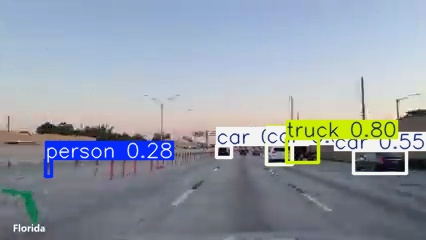

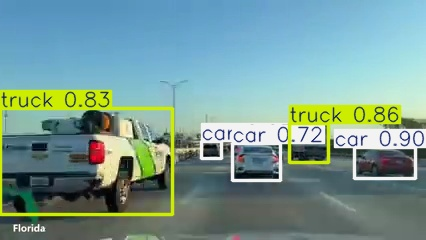

In [5]:
sample_dir = Path("frames")
sample_images = [sample_dir / "00050.jpg", sample_dir / "00200.jpg"]
for img_path in sample_images:
    if not img_path.exists():
        raise FileNotFoundError(f"Missing image: {img_path}")
sample_results = model([str(p) for p in sample_images])
for r in sample_results:
    r.save(filename=str(sample_dir / f"{Path(r.path).stem}_pred.jpg"))
    display(Image(filename=str(sample_dir / f"{Path(r.path).stem}_pred.jpg")))

## 5. Lane Subdivision & Isolation

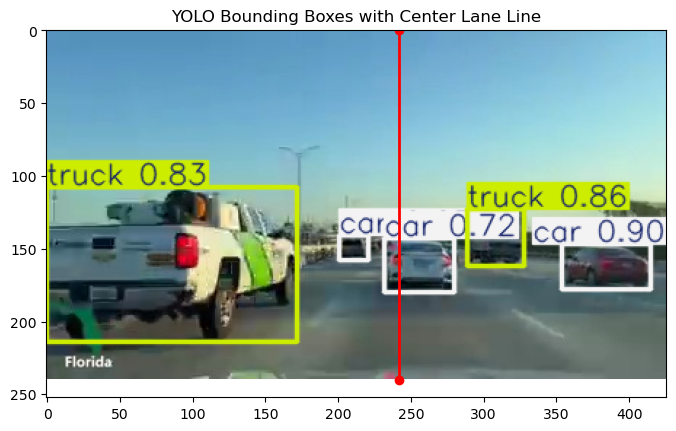

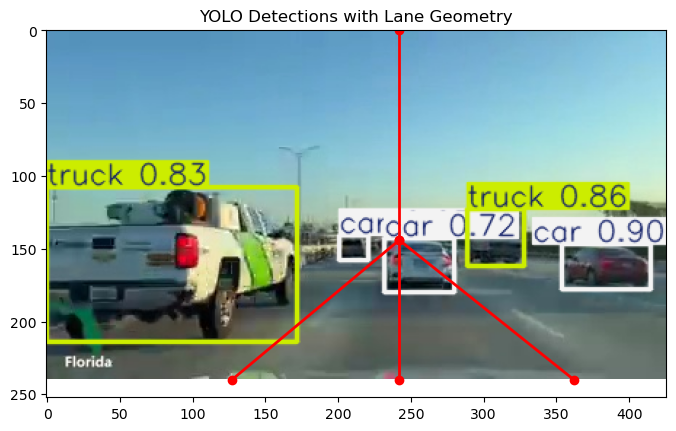

In [6]:
def plot_yolo_with_center_lane(result):
    img_bgr = result.plot()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    height, width = img_rgb.shape[:2]

    # Define center line x-coordinate
    x_center = int(0.57 * width)

    # Plot image 
    plt.figure(figsize=(8, 5))
    plt.imshow(img_rgb)

    # Draw vertical red center line
    plt.plot([x_center, x_center], [0, height], color='red', linewidth=2, marker='o')

    # Formatting
    plt.title("YOLO Bounding Boxes with Center Lane Line")
    plt.grid(False)
    plt.axis(True) 
    plt.show()

def plot_geometry_on_yolo_frame(result):
    img = result.plot() 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    YMAX, XMAX = img.shape[:2]

    # Lane center and boundaries using geometry
    x_center = int(0.57 * XMAX)
    x_left = int(0.30 * XMAX)
    x_right = int(0.85 * XMAX)

    # Plot image 
    plt.figure(figsize=(8, 5))
    plt.imshow(img_rgb)

    # Draw vertical center line
    plt.plot([x_center, x_center], [0, YMAX], color='red', linewidth=2, marker='o')

    # Draw diagonal lane boundary lines
    plt.plot([x_left, x_center], [YMAX, int(0.6 * YMAX)], color='red', linewidth=2, marker='o')
    plt.plot([x_right, x_center], [YMAX, int(0.6 * YMAX)], color='red', linewidth=2, marker='o')

    plt.title("YOLO Detections with Lane Geometry")
    plt.grid(False)
    plt.axis(True)  
    plt.show()

plot_yolo_with_center_lane(sample_results[1])
plot_geometry_on_yolo_frame(sample_results[1])


## 6. Normalize Bounding Boxes

In [7]:
def process_detections(result):
    boxes = result.boxes
    img = cv2.imread(result.path)
    h, w = img.shape[:2]
    xyxy = boxes.xyxy.cpu().numpy()
    cls = boxes.cls.cpu().numpy()
    names = result.names
    data = []
    for i in range(len(xyxy)):
        x1, y1, x2, y2 = xyxy[i]
        cls_name = names[int(cls[i])]
        x_center = (x1 + x2) / 2 / w
        y_center = (y1 + y2) / 2 / h
        area_norm = ((x2 - x1) * (y2 - y1)) / (w * h)
        nearby = area_norm > 0.05
        data.append({
            "name": cls_name, "x_center": x_center, "y_center": y_center,
            "area_norm": area_norm, "nearby": nearby
        })
    return pd.DataFrame(data, columns=["name", "x_center", "y_center", "area_norm", "nearby"])

process_detections(sample_results[1]).head()

,name,x_center,y_center,area_norm,nearby
0,car,0.903826,0.678363,0.018363,False
1,truck,0.725122,0.595270,0.014644,False
2,truck,0.202606,0.674511,0.178306,True
3,car,0.602587,0.674214,0.017311,False
4,car,0.496371,0.625754,0.003235,False


## 7. Run YOLO on All Extracted Frames

In [8]:
frame_list = sorted([str(p) for p in sample_dir.glob("*.jpg") if not p.name.endswith("_pred.jpg")])
all_results = model(frame_list)
for r in all_results:
    r.save(filename=str(sample_dir / f"{Path(r.path).stem}_pred.jpg"))


0: 384x640 1 kite, 132.9ms
1: 384x640 2 cars, 132.9ms
2: 384x640 (no detections), 132.9ms
3: 384x640 3 trucks, 132.9ms
4: 384x640 3 cars, 1 truck, 132.9ms
5: 384x640 1 person, 3 cars, 2 trucks, 132.9ms
6: 384x640 4 cars, 3 trucks, 132.9ms
7: 384x640 5 cars, 1 truck, 132.9ms
8: 384x640 4 cars, 1 bus, 1 truck, 132.9ms
9: 384x640 2 cars, 132.9ms
10: 384x640 2 cars, 1 truck, 1 bird, 132.9ms
11: 384x640 11 cars, 3 trucks, 132.9ms
12: 384x640 2 cars, 1 truck, 132.9ms
13: 384x640 5 cars, 3 trucks, 132.9ms
14: 384x640 7 cars, 3 trucks, 132.9ms
15: 384x640 3 cars, 1 truck, 132.9ms
16: 384x640 5 cars, 1 truck, 132.9ms
17: 384x640 1 truck, 132.9ms
18: 384x640 1 truck, 132.9ms
19: 384x640 5 cars, 132.9ms
20: 384x640 3 cars, 2 trucks, 132.9ms
21: 384x640 8 cars, 1 truck, 132.9ms
22: 384x640 5 cars, 3 trucks, 132.9ms
23: 384x640 1 truck, 132.9ms
24: 384x640 2 cars, 3 trucks, 132.9ms
25: 384x640 6 cars, 2 trucks, 132.9ms
26: 384x640 6 cars, 2 trucks, 132.9ms
27: 384x640 1 person, 4 cars, 1 truck, 13

## 8. Time Series Analysis

In [9]:
def extract_time_series(results):
    cars, trucks, nearby_counts = [], [], []

    for r in results:
        df = process_detections(r)
        if "name" not in df.columns:
            cars.append(0)
            trucks.append(0)
            nearby_counts.append(0)
            continue

        cars.append((df["name"] == "car").sum())
        trucks.append((df["name"] == "truck").sum())
        nearby_counts.append(df["nearby"].sum())

    return cars, trucks, nearby_counts

car_series, truck_series, nearby_series = extract_time_series(all_results)
time_stamps = np.arange(len(car_series)) * 10

### Plots for Traffic Patterns Over Time

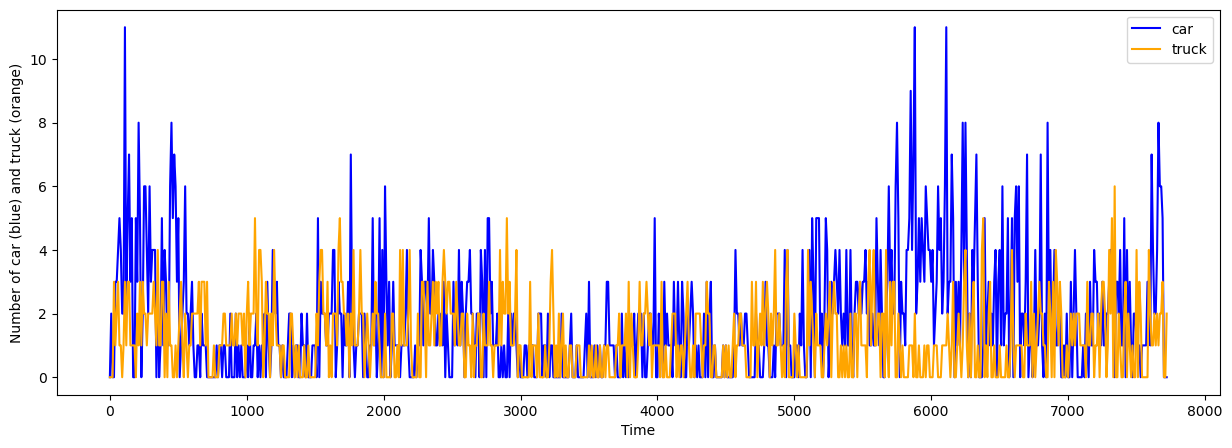

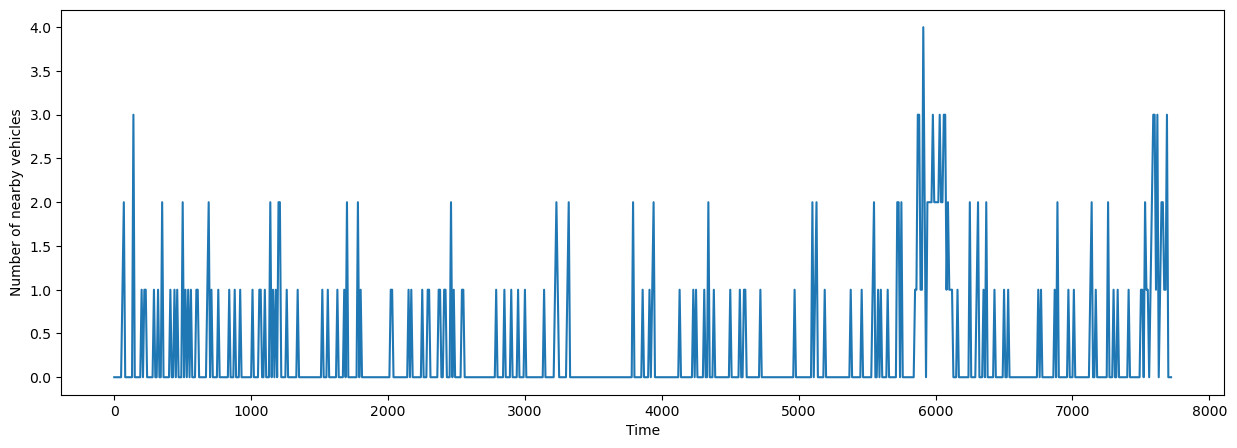

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(time_stamps, car_series, label='car', color='blue')
plt.plot(time_stamps, truck_series, label='truck', color='orange')
plt.xlabel("Time")
plt.ylabel("Number of car (blue) and truck (orange)")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(time_stamps, nearby_series)
plt.xlabel("Time")
plt.ylabel("Number of nearby vehicles")
plt.show()


Note: Chat-GPT 4o model has been used to refine this code for clarity and safety. 